## **Notebook PC#03**
## Regularized ELM Classifier for the MNIST and CIFAR-10 database. Designed from scratch.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Ariel Góes de Castro <br>
**Aluno(a):** Francisco Germano Vogt <br>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import mnist

In [2]:


(Xp, y), (Xtp, yt) = mnist.load_data()
Xa = Xp.reshape(Xp.shape[0], 784)
Xta = Xtp.reshape(Xtp.shape[0], 784)
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

11490434/11490434 [==============================] - 1s 0us/step
Shape of X:  (60000, 784)
Shape of y:  (60000,)
Shape of Xt:  (10000, 784)
Shape of yt:  (10000,)


In [3]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical
import plotly.express as px

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [4]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (42000, 784)
y_training:          (42000, 10)
X_validation:        (18000, 784)
y_validation:        (18000, 10)
X_training_elm:      (42000, 785)
X_validation_elm:    (18000, 785)


In [5]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_

In [6]:
def leaky_relu(table):
    return np.where(table > 0, table,  0.02 * table)

def relu(table):
    return np.where(table > 0, table,  0)

def get_h(X, V, activation_function):
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, y, c):
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None) # 'w' are the weights for the output layer of the ELM model. Find an approximate solution to a system of linear equations in the form A @ x = b
    return w

In [7]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []

    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)

        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [8]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs (features) for the MNIST dataset: 785
# Take 1000 hidden neurons for the MNIST dataset
V  = sigma * np.random.randn(785, 1000)

In [9]:
c_values = [pow(2,d) for d in range(-16, 15, 2)] # Range goes up to 15 to ensure search up to 2^14

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384


In [10]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384


Best c value: 4 
Performance of this value: 0.9368888888888889


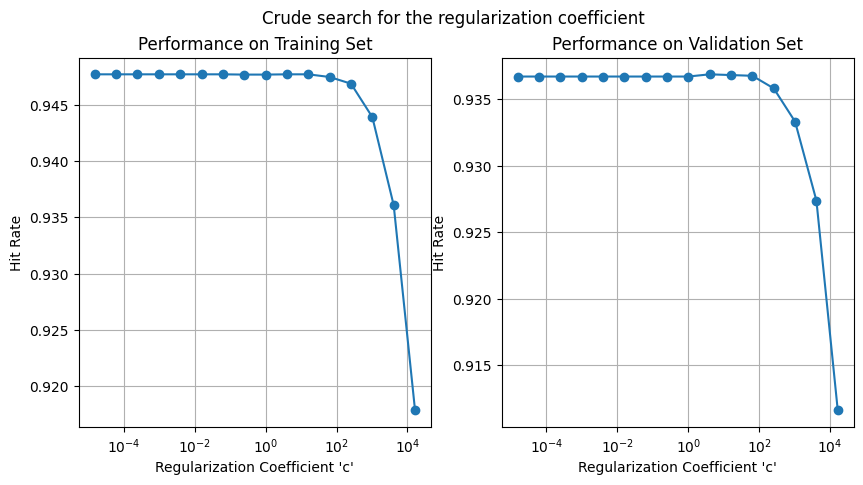

In [11]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training Set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation Set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


**Nota**: Ao analisar o gráfico da direita acima, só corrija o intervalo de busca caso não haja uma queda de desempenho para valores elevados do coeficiente de regularização. Caso o melhor coeficiente de regularização seja o de menor valor, siga adiante, pois isso indica a ausência de necessidade de regularizar esta solução.

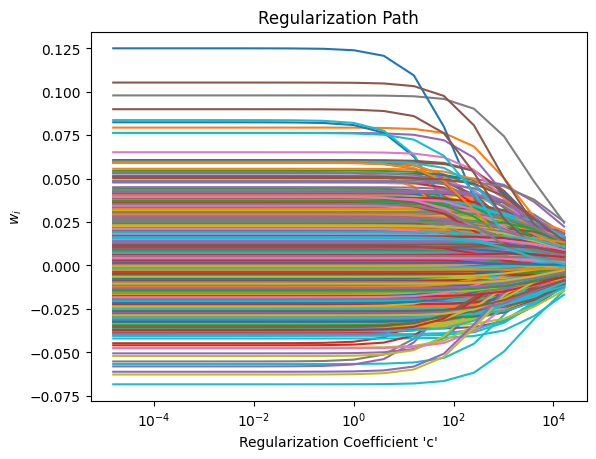

In [12]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=10)
    plt.ylabel(r"$w_i$", fontsize=10)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

<font color="green">
Atividade (a) <br>
Explique o comportamento das curvas [Regularization Path] e [Performance on Validation Set] logo acima, vinculando os seus comportamentos. <br>
</font>

Resposta:

Similar aos exercícios anteriores, é realizado uma regularização do coeficiente. No caso de ELMs, esse processo é feito com o intuito de maximizar as chances de aumentar as capacidades de generalização do modelo, visto que as funções-base utilizadas na camada intermediária são arbitrárias - ao contrário de MLPs, por exemplo.

No gráfico "Regularization Path", em uma visão geral, os pesoss estão sendo normalizados (eixo Y) de acordo com os valores dos coeficientes utilizados (eixo X). Conforme os valores dos pesos vão crescendo, os valores dos pesos estão menos espaçados, aproximando-se de zero. Enquanto isso, no gráfico de validação esse valor se mantém com uma elevada taxa de acerto até chegar na região de 10^2. O que indica que a faixa de valores dos pesos ideal é na região do gráfico em torno de 10^2. Se os pesos forem mais afunilados do que isso, a taxa de acertos começa a cair drasticamente, gerando underfit.

Por fim, de modo geral, a regularização de uma rede tem prós e contras. De forma similar à regressão Ridge (L2) que reduz a complexidade do modelo, ao reduzir o a influência dos pesos, previne-se o overfitting porque o intervalo de valores possíveis que o modelo pode assumir se torna mais limitado. Por outro lado, se esse espaço de valores se tornar muito limitado, o modelo pode se tornar enviesado (biased), se comportando muito bem apenas para os dados de treinamento e incapaz de generlizar para dados de validação.

In [13]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

1.0
2.5
4.0
5.5
7.0
8.5
10.0
11.5
13.0
14.5
16.0


In [14]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

1.0
2.5
4.0
5.5
7.0
8.5
10.0
11.5
13.0
14.5
16.0


Best c value: 4.0 
Performance of this value: 0.9368888888888889


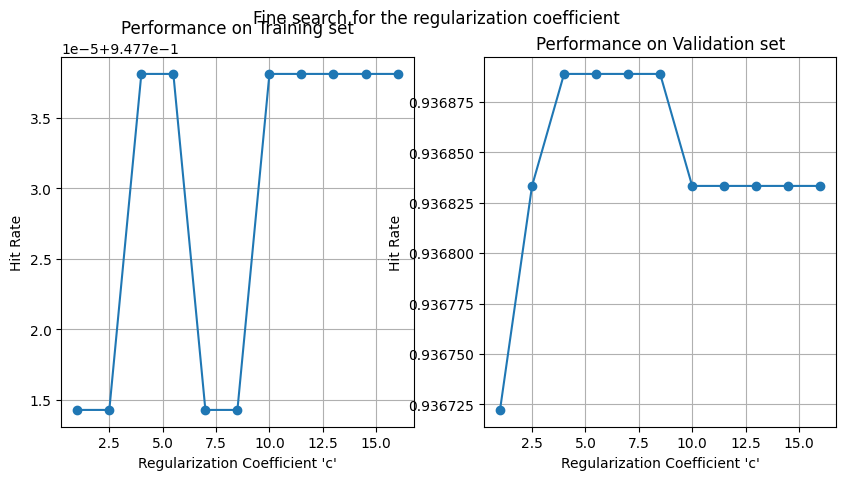

In [15]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [16]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c) # Ws is a vector of weight matrices, while W_elm is the "final" matrix with the best value of coeficient C - i.e., assuming the user-defined range of search

In [17]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.9454


,0,1,2,3,4,5,6,7,8,9
0,967,0,11,2,0,8,7,3,5,5
1,1,1121,2,2,4,1,3,21,3,7
2,1,2,962,8,4,0,3,17,6,2
3,0,1,9,948,1,18,0,4,16,11
4,0,1,8,1,925,6,11,1,10,23
5,5,1,0,15,0,833,9,3,15,9
6,4,4,8,1,8,9,924,1,8,3
7,1,1,9,8,1,2,0,951,8,15
8,1,4,21,14,5,9,1,3,896,7
9,0,0,2,11,34,6,0,24,7,927


<font color="green">
Atividade (b) <br>
O que sustenta o ganho de desempenho na taxa de acerto de classificação quando comparado ao classificador linear do PC01? Repare que a estratégia de otimização é a mesma nos dois casos. <br>
</font>

Resposta:

ELMs tem um grande diferencial: camadas escondidas. Diferente de um modelo puramente linear, com pelo menos uma cada intermediária com funções não-lineares é possível que o modelo tenha a capacidade de aprender relações não-lineares mais complexas entre a entrada de dados e a classe final. Especificamente, em redes ELMs, uma das formas utilizadas para treiná-la é atribuir pesos arbitrários à camada escondiada. Dessa forma, o problema passa a ser a o mapeamento entre a saída da camada escondida e a camada final, onde o modelo deverá linearizar as saidas com hiperplanos capazes de distinguir entre as classes.

Image no. 63


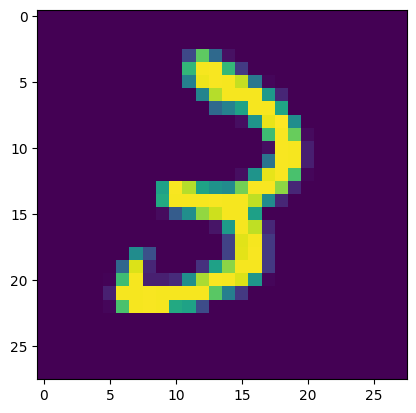

Real: 3
Predicted: 2
Rank of the correct answer: 2
Probabilities: [-0.01812548 -0.09228769  0.56359559  0.46374548 -0.04075041  0.05618693
 -0.10249154 -0.05721609  0.03919743  0.20847625] 

Image no. 115


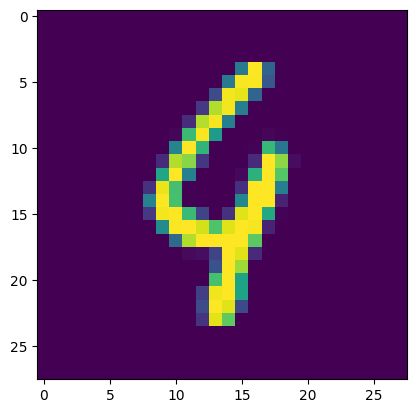

Real: 4
Predicted: 9
Rank of the correct answer: 2
Probabilities: [-0.08206339  0.08160104 -0.03344121 -0.09758998  0.41365743  0.03838523
  0.19662836 -0.04917194  0.13040202  0.43250476] 

Image no. 149


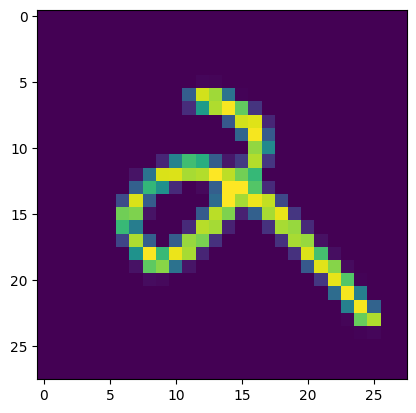

Real: 2
Predicted: 8
Rank of the correct answer: 4
Probabilities: [ 0.04766327  0.13117538  0.16404552  0.23744726  0.09075411 -0.31041378
  0.22325418 -0.00701361  0.31947076  0.1085679 ] 

Image no. 193


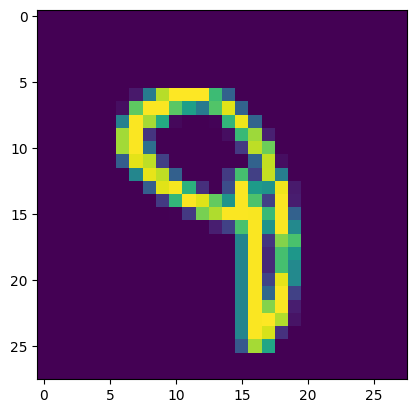

Real: 9
Predicted: 4
Rank of the correct answer: 3
Probabilities: [ 0.04087181  0.02944486  0.03821639  0.07700025  0.29734472  0.05189895
  0.03373531  0.23401807 -0.06892126  0.18361136] 

Image no. 195


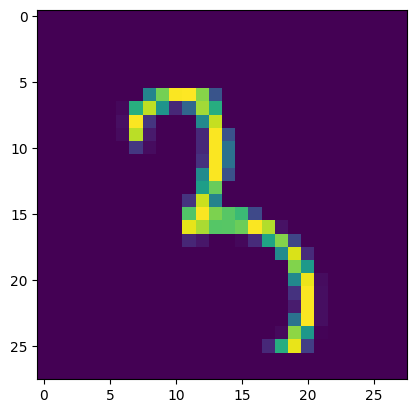

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [-0.0051626   0.12103629  0.09032021  0.23949171  0.04912903  0.24125823
  0.07823574 -0.04863774  0.03991513  0.12707521] 



In [18]:
# Devoted solely to the MNIST dataset
def find_pos(item, lst):
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z]
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")

##Repetindo os principais passos, agora para a base CIFAR-10.

In [ ]:
from keras.datasets import cifar10

(Xp, y), (Xtp, yt) = cifar10.load_data()
Xa = Xp.reshape(Xp.shape[0], 3072)
Xta = Xtp.reshape(Xtp.shape[0], 3072)
y = y.ravel()
yt = yt.ravel()
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

yy = to_categorical(y)
yyt = to_categorical(yt)

Shape of X:  (50000, 3072)
Shape of y:  (50000,)
Shape of Xt:  (10000, 3072)
Shape of yt:  (10000,)


In [ ]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (35000, 3072)
y_training:          (35000, 10)
X_validation:        (15000, 3072)
y_validation:        (15000, 10)
X_training_elm:      (35000, 3073)
X_validation_elm:    (15000, 3073)


In [ ]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs (features) for the CIFAR10 dataset: 3073
# Take 2000 hidden neurons for the CIFAR10 dataset.
V  = sigma * np.random.randn(3073, 2000)

In [ ]:
c_values = [pow(2,d) for d in range(-8, 21, 2)] # Range goes up to 21 to ensure search up to 2^20

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144
1048576


In [ ]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144
1048576


Best c value: 4096 
Performance of this value: 0.4566


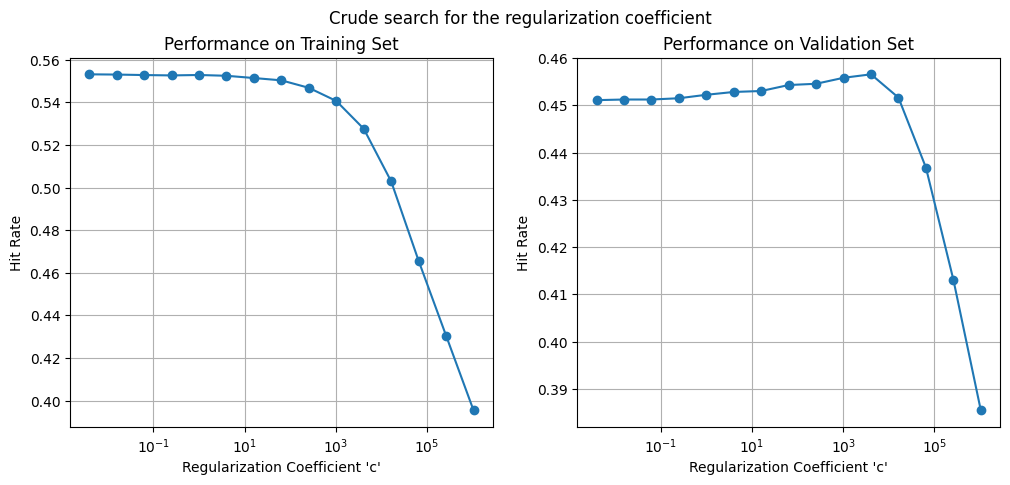

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training Set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation Set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


**Nota**: Ao analisar o gráfico da direita acima, só corrija o intervalo de busca caso não haja uma queda de desempenho para valores elevados do coeficiente de regularização. Caso o melhor coeficiente de regularização seja o de menor valor, siga adiante, pois isso indica a ausência de necessidade de regularizar esta solução.

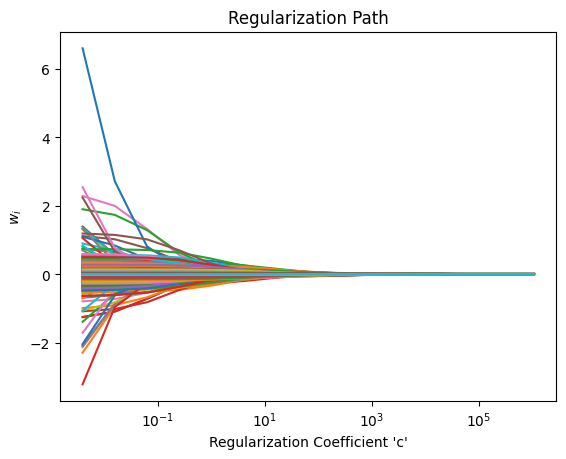

In [ ]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=10)
    plt.ylabel(r"$w_i$", fontsize=10)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [ ]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


In [ ]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


Best c value: 5632.0 
Performance of this value: 0.4572


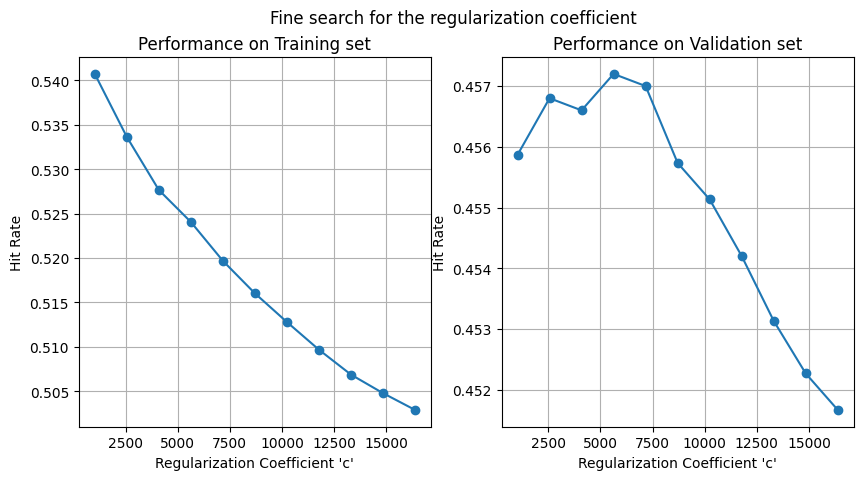

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [ ]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [ ]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.4607


,0,1,2,3,4,5,6,7,8,9
0,514,40,109,54,65,25,15,44,98,38
1,43,567,55,62,30,39,42,45,81,195
2,43,11,302,68,125,80,75,46,7,14
3,15,22,67,228,41,155,52,55,12,19
4,28,11,112,51,361,75,92,66,14,5
5,15,17,79,188,55,358,62,69,23,16
6,27,33,124,158,153,89,563,42,14,35
7,43,50,78,79,105,86,51,530,23,53
8,213,82,40,38,44,57,25,34,657,98
9,59,167,34,74,21,36,23,69,71,527


<font color="green">
Atividade (c) <br>
No link a seguir, afirma-se que uma das vantagens das ELMs é que elas [can learn from the training data in one step, without repeating the learning process in multiple steps.] Não foi o que fizemos neste PC03. Qual é o risco de treinar uma ELM em apenas um passo? <br>
</font>

[Extreme Learning Machine - Advantage of ELM](https://www.geeksforgeeks.org/extreme-learning-machine/)

Resposta:

De fato, dado que a responsabilidade final de garantir uma boa otimização em uma ELM fica majoritariamente na última camada, o desejável é garantir um elevado número de neurônios na camada intermediária. Dessa forma, as chances de se obter mapeamentos que possam estar vinculados às demandas da aplicação aumenta em um único passo. No entanto, existem o risco de que a inicialização dos pesos de forma aleatória na camada intermediária não consiga se ajustar propriamente aos dados de forma a obter saídas desejadas em uma única iteração. Resumindo, temos dois problemas ao realizar o treinamento em um único passo: (i) falta de otimização dos neurônios durante o treinamento e; (ii) sensibilidade aos valores aleatórios de pesos no momento da inicialização, levando a resultados sub-ótimos para diferentes seeds.

<font color="green">
Atividade (d) <br>
Uma vez treinada uma ELM, que estratégia você adotaria para eliminar neurônios da camada intermediária, caso uma implementação prática indicasse uma limitação de memória? A sua resposta deve propor uma subrede ELM extraída da rede ELM completa já treinada, capaz de exibir máximo desempenho de generalização. Considere que o número de neurônios que precisam ser eliminados é uma porcentagem arbitrária do número total. Considere também que a sua estratégia não deve se basear na amplitude dos pesos individuais da camada de saída (essa seria uma estratégia possível, mas não deve ser adotada aqui). <br>
</font>

Resposta:
Segundo [BARTLETT (1997)](https://proceedings.neurips.cc/paper_files/paper/1996/hash/fb2fcd534b0ff3bbed73cc51df620323-Abstract.html), é mais importante realizar esforços para controlar a norma dos pesos em uma ELM do que focar propriamente no número de neurônios necessários. Além disso, se a rede possuir a quantidade mínima de neurônios para captar as nuâncias do modelo a ser generalizado, a adição de mais neurônios pode trazer um ganho mínimo em relação a um custo elevado de computação.

Sabendo disso, um conjunto de passos que poderia ser aplicado como uma estratégia para eliminar os neurônios da camada intermediária que menos influenciam na aprendizagem do modelo poderia se basear em analisar a matriz H, através da função `get_h` e:

1. Eliminar inicialmente as colunas que estão completamente zeradas (se existir);
2. Padronizar os dados de entrada para garantir que todos os recursos tenham a mesma escala. Isso facilita a comparação entre os neurônios e torna a seleção mais robusta. Por exemplo, utilizando a função softmax
3. Aplicar técnicas como PCA ou t-SNE para reduzir o número de features, se necessário. Isso diminui a carga computacional e pode facilitar a identificação de neurônios redundantes.
4. Medir como a acurácia do modelo muda quando um neurônio é removido. Esse passo pode ser feito iterativamente, armazendo os neurônios retirados e "recolocando-os" novamente se o desempenho cair conideravelmente.
5. Após a seleção dos neurônios, reajustar os pesos da subrede ELM para otimizar o desempenho.
6. Comparar o desempenho da subrede ELM com a rede ELM completa em termos de acurácia de generalização em um conjunto de teste independente.

In [19]:
print(get_h(X_training_elm, V, relu))

[[2.13367231 0.         0.76173229 ... 0.         0.         1.89343428]
 [3.37606718 0.         0.         ... 0.         1.68429594 0.24512911]
 [0.83580493 0.         0.         ... 0.         3.7370245  1.50710261]
 ...
 [1.60849792 0.         0.         ... 0.         0.         0.        ]
 [1.20408508 0.         0.46718865 ... 0.         1.50659947 0.60647129]
 [3.08682483 0.         1.53381223 ... 0.         1.35779837 0.        ]]
